In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [63]:
df = pd.read_csv('data/temp_data_cleaned.csv', index_col=0)

### Stationarize the data in preperation to pass to ARIMA
- we do not have to treat for Variance and Trend! (see exploratory script)
- we do have to treat for **seasonality**


#### create datetime index


In [64]:
df.index = pd.to_datetime(df.index)
df.head(3)

,TG
DATE,
1876-01-01,275.35
1876-01-02,275.65
1876-01-03,273.45


In [65]:
# take 29th februar out (leap years)
df = df[~((df.index.month == 2) & (df.index.day == 29))]

In [66]:
# create month and daycolumn from DATETIME index 
df['month'] = df.index.month
df['day'] = df.index.day
df.head(2)

,TG,month,day
DATE,,,
1876-01-01,275.35,1,1
1876-01-02,275.65,1,2


#### remove Seasonality

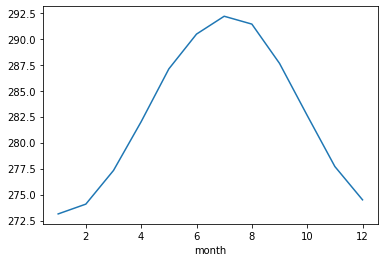

In [67]:
# groupby month
df['month'] = df.index.month
mm_temp = df.groupby('month')['TG'].mean()
mm_temp.plot() # SEASONALITY

In [68]:
# daily means
df['daily_means'] = df.groupby(['day', 'month'])['TG'].transform('mean')

In [69]:
df['stationary_TG'] = df.TG - df.daily_means

In [70]:
df.head()

,TG,month,day,daily_means,stationary_TG
DATE,,,,,
1876-01-01,275.35,1,1,273.255517,2.094483
1876-01-02,275.65,1,2,273.512069,2.137931
1876-01-03,273.45,1,3,273.654138,-0.204138
1876-01-04,267.35,1,4,273.561724,-6.211724
1876-01-05,263.35,1,5,273.358276,-10.008276


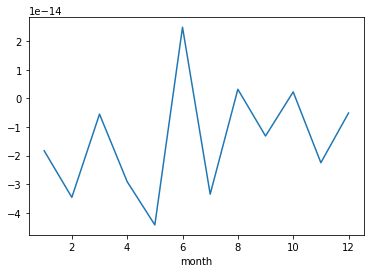

In [71]:
mm_temp = df.groupby('month')['stationary_TG'].mean()
mm_temp.plot()

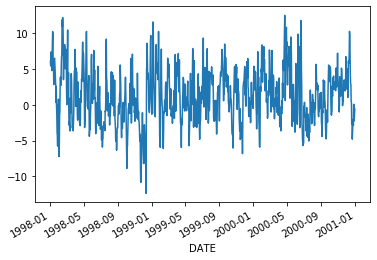

In [72]:
# subset of df
plot_df = df.loc['1998-01-01':'2000-12-31']
plot_df.stationary_TG.plot()

### Train-test split

In [73]:
train = df.loc[:'2018-12-31']['stationary_TG']
test = df.loc['2019-01-01':'2019-12-31']['stationary_TG']
# test is one year -> lag has to be 365

### ARIMA

#### Parameters to ARIMA:
* The training data
* The order:
    * p - autoregressive part (regression on the X data, 0 to 3) - FIRST PARAMETER
    * d - integration (0 or 1) - SECOND PARAMETER
    * q - moving average part (of the residuals!!, 0 to 3) = THIRD PARAMETER

In [74]:
from statsmodels.tsa.arima_model import ARIMA

In [75]:
m = ARIMA(train, order=(1,0,1))

/Users/lara/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [76]:
m_fit = m.fit()

### Forecast future data
* We just need to define the # of time steps to be predicted
* output = tuple with the forecast, the standard error and the confidence intervals

In [77]:
output = m_fit.forecast(steps=365)

In [78]:
ypred = output[0]

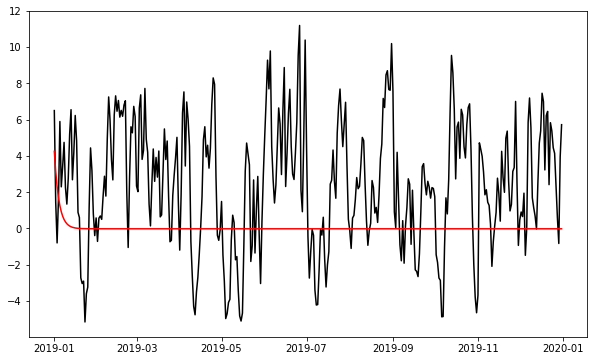

In [79]:
# plot test data and predictions
plt.figure(figsize=(10,6))
plt.plot(test.index, test, color='black')
plt.plot(test.index, ypred, color='red')

#### Reconstruct
- to make the predictions useful, we need to reconstruct the data back into its original form

1. concatenate the ytest data with the ypred on the colum space -> use this recombined dataframe to recounstruct ypred 
2. reseason by adding back in the daily - monthly means ?

In [80]:
original = df.loc['2019-01-01':'2019-12-31']
original

,TG,month,day,daily_means,stationary_TG
DATE,,,,,
2019-01-01,279.75,1,1,273.255517,6.494483
2019-01-02,274.95,1,2,273.512069,1.437931
2019-01-03,272.85,1,3,273.654138,-0.804138
2019-01-04,275.25,1,4,273.561724,1.688276
2019-01-05,279.25,1,5,273.358276,5.891724
...,...,...,...,...,...
2019-12-27,276.25,12,27,273.822917,2.427083
2019-12-28,274.45,12,28,273.864583,0.585417
2019-12-29,273.15,12,29,273.984722,-0.834722


In [81]:
# create prediction df
prediction = pd.DataFrame(ypred, index=original.index, columns=['prediction'])

In [82]:
#concat original df and ypred
pred = pd.concat([prediction, original], axis=1)

In [83]:
pred

,prediction,TG,month,day,daily_means,stationary_TG
DATE,,,,,,
2019-01-01,4.248053,279.75,1,1,273.255517,6.494483
2019-01-02,3.131283,274.95,1,2,273.512069,1.437931
2019-01-03,2.306370,272.85,1,3,273.654138,-0.804138
2019-01-04,1.697039,275.25,1,4,273.561724,1.688276
2019-01-05,1.246950,279.25,1,5,273.358276,5.891724
...,...,...,...,...,...,...
2019-12-27,-0.025196,276.25,12,27,273.822917,2.427083
2019-12-28,-0.025196,274.45,12,28,273.864583,0.585417
2019-12-29,-0.025196,273.15,12,29,273.984722,-0.834722


In [84]:
#1: reseason our data
pred['reseasoned_pred'] = pred.prediction + pred.daily_means

In [85]:
pred

,prediction,TG,month,day,daily_means,stationary_TG,reseasoned_pred
DATE,,,,,,,
2019-01-01,4.248053,279.75,1,1,273.255517,6.494483,277.503570
2019-01-02,3.131283,274.95,1,2,273.512069,1.437931,276.643352
2019-01-03,2.306370,272.85,1,3,273.654138,-0.804138,275.960507
2019-01-04,1.697039,275.25,1,4,273.561724,1.688276,275.258763
2019-01-05,1.246950,279.25,1,5,273.358276,5.891724,274.605226
...,...,...,...,...,...,...,...
2019-12-27,-0.025196,276.25,12,27,273.822917,2.427083,273.797721
2019-12-28,-0.025196,274.45,12,28,273.864583,0.585417,273.839387
2019-12-29,-0.025196,273.15,12,29,273.984722,-0.834722,273.959526


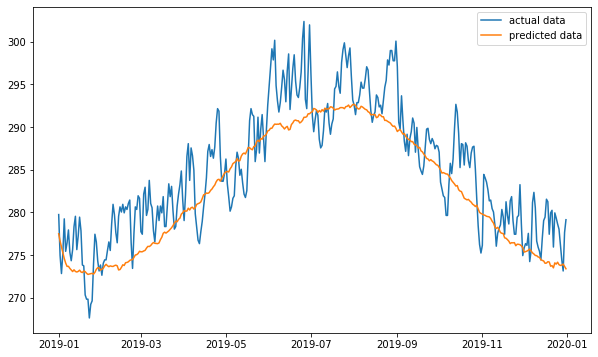

In [86]:
# plot test data and reseasoned predictions
plt.figure(figsize=(10,6))
plt.plot(pred.index, pred['TG'])
plt.plot(pred.index, pred['reseasoned_pred'])
plt.legend(['actual data' , 'predicted data'])

In [87]:
print(m_fit.summary())

                              ARMA Model Results                              
Dep. Variable:          stationary_TG   No. Observations:                52195
Model:                     ARMA(1, 1)   Log Likelihood             -115976.538
Method:                       css-mle   S.D. of innovations              2.232
Date:                Fri, 11 Sep 2020   AIC                         231961.076
Time:                        16:13:07   BIC                         231996.527
Sample:                             0   HQIC                        231972.159
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0252      0.045     -0.565      0.572      -0.113       0.062
ar.L1.stationary_TG     0.7387      0.004    200.698      0.000       0.731       0.746
ma.L1.stationary

                  0
count  52195.000000
mean      -0.000022
std        2.232343
min      -14.144375
25%       -1.390331
50%        0.014953
75%        1.437916
max       11.290372


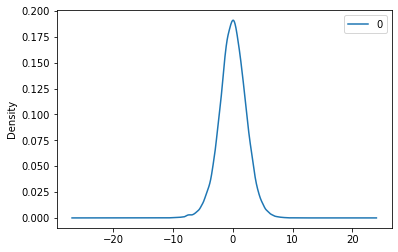

In [88]:
# plot residual error
residuals = pd.DataFrame(m_fit.resid)
#residuals.plot()
residuals.plot(kind='kde') # density plot of the residual error values, 
# suggesting the errors are Gaussian, but may not be centered on zero.
print(residuals.describe())

### Check auto-correlation

In [89]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

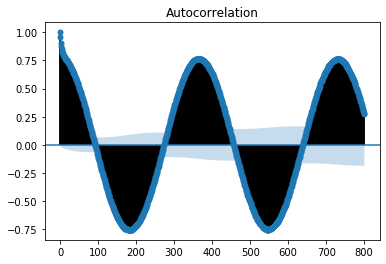

In [90]:
acf_temp_lag = plot_acf(df.TG, lags=800) # None, 100, 800

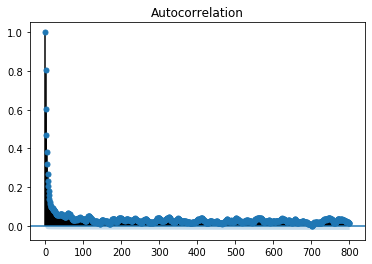

In [91]:
acf_stationary_temp_lag = plot_acf(df.stationary_TG, lags=800) # None, 100, 800

In [92]:
# plot of the stationarised data
# create the plot with the data that you want to feed into the model  
# here we can detect if there is a pattern in the data that does not exist because of autocorrelation
# Is it just random noise?
# AC plot measures if there's something you can put into the model 
# the bars that are not in the confidence intervals ! 

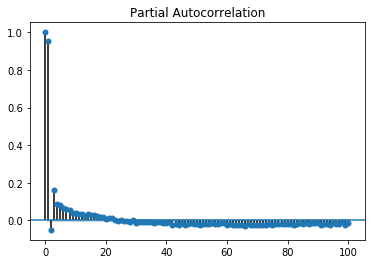

In [93]:
from statsmodels.graphics.tsaplots import plot_pacf
pacf_TG_stat = plot_pacf(df.TG, lags=100)

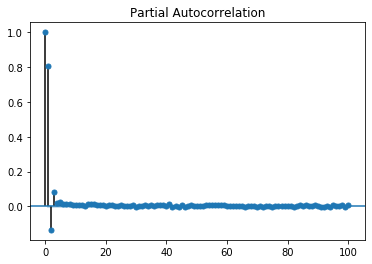

In [94]:
pacf_TG_stat = plot_pacf(df.stationary_TG, lags=100)

In [95]:
from sklearn import metrics

print(metrics.mean_absolute_error(test, ypred))

3.418675423056016


/Users/lara/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


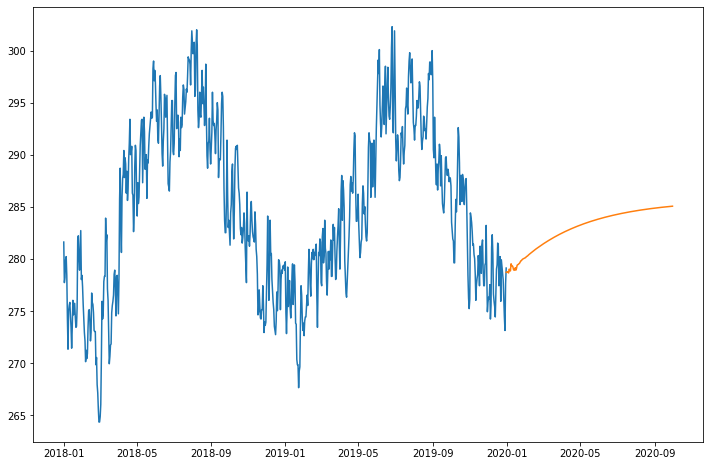

In [100]:
from statsmodels.tsa.ar_model import AR

sub_df = df.loc['2018-01-01':'2019-12-31']
ar = AR(sub_df['TG'])
ar_fitted = ar.fit()

ypred = ar_fitted.predict(start = '2019-12-31', end='2020-09-30')
plt.figure(figsize=(12,8))
plt.plot(sub_df['TG'])
plt.plot(ypred)
